**Imports**

In [97]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

**Load data**

In [ ]:

# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 

**Prepare data**

In [78]:
# convert object data type to numericals
for column in X:
    if X[column].dtype == 'object':
        X[column] = X[column].astype('category').cat.codes
        
# split data into train, validation & test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train, X_val, y_val, y_test = train_test_split(X_train, y_train, train_size=0.75, random_state=42)


**Data exploration \(based on training data\)**

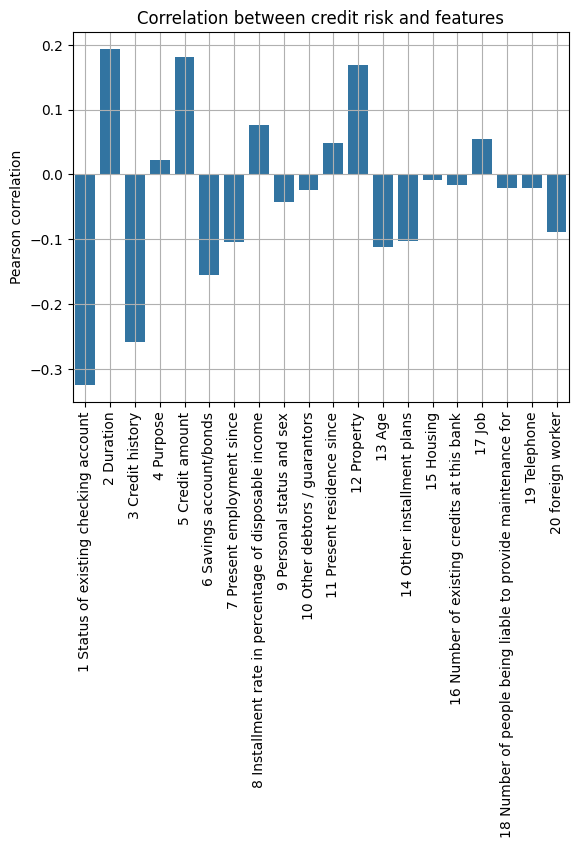

In [ ]:
# Do linear correlation assessement
correlation_corr = []
attributes = []
for idx, (column, attribute_name) in enumerate(zip(X_train, statlog_german_credit_data.variables.description)):
    correlation_corr.append(X_train[column].corr(y_train['class']))
    attributes.append(str(idx+1) + " " + attribute_name)

# plot results
sns.barplot(x=attributes, y=correlation_corr)
plt.title('Correlation between credit risk and features')
plt.xticks(rotation = 90)
plt.ylabel('Pearson correlation')
plt.grid()